In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
Nu = 0.12   
Ns = 0.012

In [3]:
def nlm_lf(w0, bu0, bs0, nt=50000):
    w = np.zeros(nt)
    bu = np.zeros(nt)
    bs = np.zeros(nt)
    
    w[0] = w0
    bs[0] = bs0
    bu[0] = bu0
    
    dt = 0.1
    
    # leap frog
    for t in range(1):
        if bs[t] > bu[t]:
            w[t+1] = w[t] + bs[t]*dt
        else:
            w[t+1] = w[t] + bu[t]*dt

        bu[t+1] = bu[t] - (Nu**2)*w[t]*dt
        bs[t+1] = bs[t] - (Ns**2)*w[t]*dt



    for t in range(1,nt-1):
        if bs[t] > bu[t]:
            w[t+1] = w[t-1] + bs[t]*2.*dt
        else:
            w[t+1] = w[t-1] + bu[t]*2.*dt

        bu[t+1] = bu[t-1] - (Nu**2)*w[t]*2.*dt
        bs[t+1] = bs[t-1] - (Ns**2)*w[t]*2.*dt
   
    return w.astype(np.float16), bu.astype(np.float16), bs.astype(np.float16)

In [4]:
nt = 50000

w0 = 0.1
bu0 = 0.1
bs0 = 0.15

w, bu, bs = nlm_lf(w0, bu0, bs0, nt=nt)

Text(0.5, 1.0, 'always in saturated phase?')

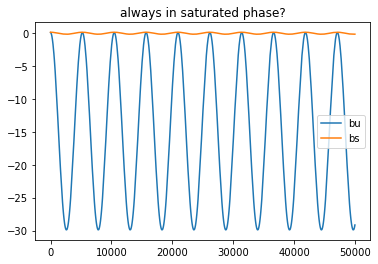

In [5]:
#plt.plot(w)
plt.plot(bu, label='bu')
plt.plot(bs, label='bs')
plt.legend()
plt.title('always in saturated phase?')

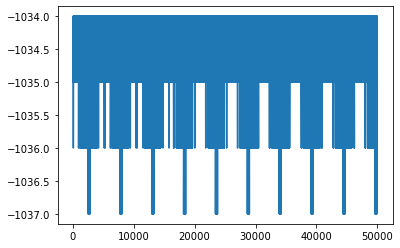

In [6]:
M = bu/Nu**2 - bs/Ns**2
plt.plot(M)

### TLM

In [7]:
def tlm_lf(w0, bu0, bs0, wp0, bup0, bsp0, nt=50000, dt=0.1):
    
    # basic state?
    w = np.zeros(nt)
    bu = np.zeros(nt)
    bs = np.zeros(nt)

    # p for prime, perturbation
    wp = np.zeros(nt)
    bup = np.zeros(nt)
    bsp = np.zeros(nt)
    
    # initial condition for basic state
    w[0] = w0
    bu[0] = bu0
    bs[0] = bs0

    # initial condition for perturbaitons are all zeros, 
    wp[0] = wp0
    bup[0] = bup0
    bsp[0] = bsp0
    
    for t in range(1):
        if bs[t] > bu[t]:
            wp[t+1] = wp[t] + dt*bup[t]
            w[t+1] = w[t] + bs[t]*dt
        else:
            wp[t+1] = wp[t] + dt*bsp[t]
            w[t+1] = w[t] + bu[t]*dt

        bup[t+1] = bup[t] - (Nu**2)*wp[t]*dt
        bu[t+1] = bu[t] - (Nu**2)*w[t]*dt
        bsp[t+1] = bsp[t] - (Ns**2)*wp[t]*dt
        bs[t+1] = bs[t] - (Ns**2)*w[t]*dt



    for t in range(1,nt-1):
        if bs[t] > bu[t]:
            w[t+1] = w[t-1] + bs[t]*2.*dt
            wp[t+1] = wp[t-1] + bsp[t]*2.*dt
        else:
            w[t+1] = w[t-1] + bu[t]*2.*dt
            wp[t+1] = wp[t-1] + bup[t]*2.*dt

        bu[t+1] = bu[t-1] - (Nu**2)*w[t]*2.*dt
        bup[t+1] = bup[t-1] - (Nu**2)*wp[t]*2.*dt
        bs[t+1] = bs[t-1] - (Ns**2)*w[t]*2.*dt
        bsp[t+1] = bsp[t-1] - (Ns**2)*wp[t]*2.*dt

    return wp.astype(np.float16), bup.astype(np.float16), bsp.astype(np.float16)

In [23]:


# initial condition for basic state
#w[0] = 0.1
#bu[0] = 0
#bs[0] = 0

# initial condition for perturbaitons are all zeros, 
#wp[0] = 1e-4
#bup[0] = 1e-5
#bsp[0] = 1e-6

# initial condition for basic state
w0 = 0.1
bu0 = 0.1
bs0 = 0.15

# initial condition for perturbaitons are all zeros, 
wp0 = 0.01
bup0 = 0.01
bsp0 = 0.01

wp, bup, bsp = tlm_lf(w0, bu0, bs0, wp0, bup0, bsp0)
tlm_pert = [wp, bup, bsp]

In [24]:
def sens_subplots(var, ax, title):
    cs = ax.plot(var)
    ax.set_title(title)

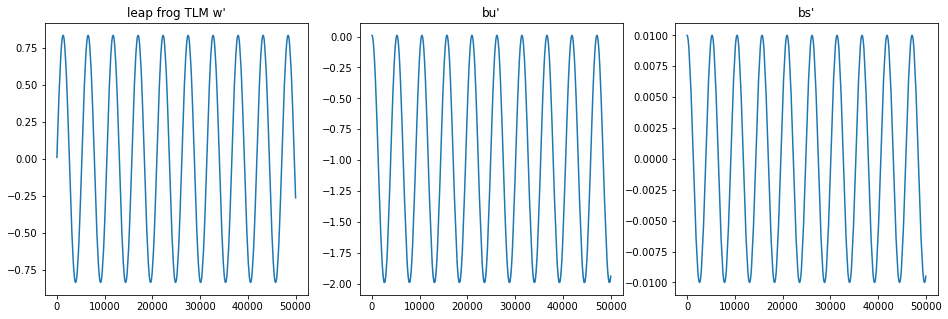

In [25]:
nrows = 1
ncols = 3
fig,ax = plt.subplots(nrows=nrows,
                      ncols=ncols, figsize=(16,5))
sens_subplots(wp, ax[0], "leap frog TLM w'")
sens_subplots(bup, ax[1], "bu'")
sens_subplots(bsp, ax[2], "bs'")

In [26]:
# initial condition for basic state
#w0 = 0.1
#bu0 = 0.1
#bs0 = 0.15

# initial condition for perturbaitons are all zeros, 
#wp0 = 0.01
#bup0 = 0.01
#bsp0 = 0.02

w_ctrl, bu_ctrl, bs_ctrl = nlm_lf(w0, bu0, bs0, nt=nt)
w_nlmp, bu_nlmp, bs_nlmp = nlm_lf(w0+wp0, bu0+bup0, bs0+bup0, nt=nt)
w_diff = w_nlmp - w_ctrl
bu_diff = bu_nlmp - bu_ctrl
bs_diff = bs_nlmp - bs_ctrl

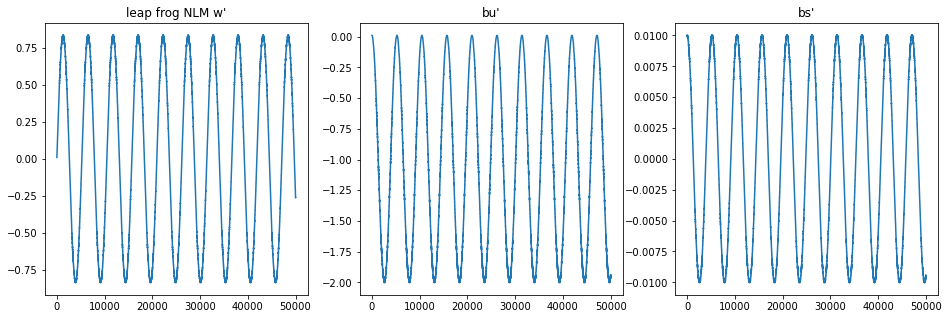

In [27]:
nrows = 1
ncols = 3
fig,ax = plt.subplots(nrows=nrows,
                      ncols=ncols, figsize=(16,5))
sens_subplots(w_diff, ax[0], "leap frog NLM w'")
sens_subplots(bu_diff, ax[1], "bu'")
sens_subplots(bs_diff, ax[2], "bs'")

In [28]:
a = pd.read_csv('fortran_moist_leapfrog/fort.16', delim_whitespace=True, 
                header=None, names=['a_w', 'a_bu', 'a_bs'])
a_w = a.a_w.values[::-1]
a_bu = a.a_bu.values[::-1]
a_bs = a.a_bs.values[::-1]

FileNotFoundError: [Errno 2] No such file or directory: '/home1/class/fall17/nchen67/moistPV/fortran_moist_leapfrog/fort.16'

NameError: name 'a_w' is not defined

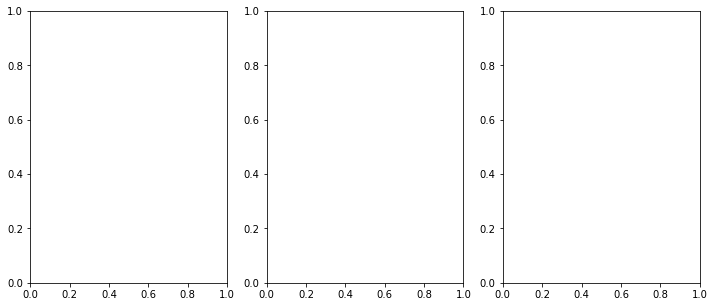

In [29]:
nrows = 1
ncols = 3
fig,ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,5))
sk = 10
sens_subplots(a_w[::sk], ax[0], 'sensitivity to w')
sens_subplots(a_bu[::sk], ax[1], 'sensitivity to bu')
sens_subplots(a_bs[::sk], ax[2], 'sensitivity to bs')

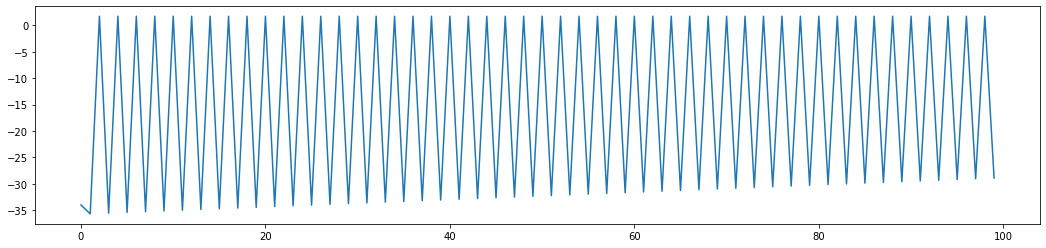

In [108]:
plt.figure(figsize=(18,4))
sk=1
plt.plot(a_w[0:100:sk])

In [91]:
a = pd.read_csv('/home1/class/fall17/nchen67/moistPV/fortran_moist_leapfrog/fort.15', delim_whitespace=True, 
                header=None, names=['w_prime', 'bu_prime', 'bs_prime'])
w_prime = a.w_prime
bu_prime = a.bu_prime
bs_prime = a.bs_prime

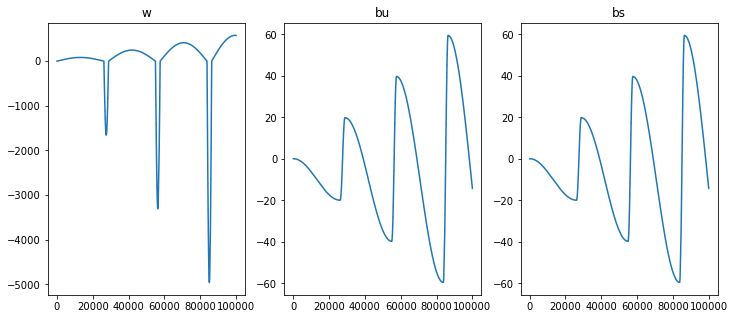

In [92]:
nrows = 1
ncols = 3
fig,ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,5))
sens_subplots(w_prime, ax[0], 'w')
sens_subplots(bu_prime, ax[1], 'bu')
sens_subplots(bu_prime, ax[2], 'bs')

In [93]:
w_prime.size, a_w.size

(99999, 100000)

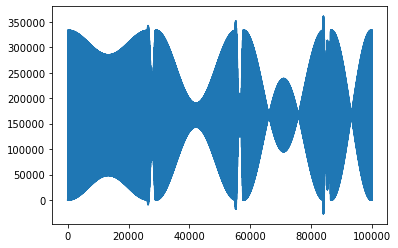

In [94]:
dR = w_prime*a_w[1:] + bu_prime*a_bu[1:] + bs_prime*a_bs[1:]
plt.plot(dR)


$$b=\begin{cases} \theta_e + \left( R_{vd}\frac{c_p\theta_0}{L_v}-1 \right) q_t \ \ \ \ \ \ \ \ \ \text{if} q_t \lt q_vs, \ b_u \\
\theta_e + \left( R_{vd}\frac{c_p\theta_0}{L_v}-1\right) q_{vs} -  \frac{c_p\theta_0}{L_v}(q_t-q_{vs})\ \  \text{if} q_t \geq q_vs, \ b_s 
\end{cases}  (2.26)$$

$$N_u^2 = \frac{g}{\theta_0}\frac{d\tilde{\theta}}{dz}   (2.29)$$
$$N_u^2 = \frac{g}{\theta_0}\frac{d\tilde{\theta_e}}{dz}$$

$$ \frac{c_p \theta_0}{L_v} \approx 0.1 \to \theta_0 = 250K$$
$$d\tilde{\theta}/dz=3K/km, d\tilde{q_v}/dz=-0.6g/kg/km, N_u^2\approx 2N_s^2$$

identify the dependent variables: <br>
w bu bs qt theta_e

dependent: w bu bs qt theta_e
independent: nt dt qvs nu ns cp lv epsi theta

$$\frac{dw}{dt}=b=N_ub_uH_u + N_sb_sH_s$$
$$\frac{db_u}{dt}=-N_uw$$
$$\frac{db_s}{dt}=-N_sw$$
$$b = H_ub_u + H_sb_s$$
$$H_u = \begin{cases} 1 \ \ \text{if} q_t \lt q_vs, \\
0 \ \  \text{if} q_t \geq q_vs
\end{cases}  (2.50)$$
$$b_u = \theta_e + (\epsilon - 1)q_t$$
$$b_s = \theta_e + (\epsilon - 1)q_{vs} - \epsilon(q_t-q_{vs}) \ \ \ \ (2.51)$$
$$\theta + Lv/Cp min(qt, qvs)= \theta_e \ \ \ \ (2.13)$$